In [2]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

c:\Users\amiri\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("data/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
edges=pd.read_csv("data/musae_git_edges.csv")
target_df=pd.read_csv("data/musae_git_target.csv")

print(target_df)

          id            name  ml_target
0          0          Eiryyy          0
1          1      shawflying          0
2          2     JpMCarrilho          1
3          3       SuhwanCha          0
4          4    sunilangadi2          1
...      ...             ...        ...
37695  37695  shawnwanderson          1
37696  37696       kris-ipeh          0
37697  37697        qpautrat          0
37698  37698        Injabie3          1
37699  37699   caseycavanagh          0

[37700 rows x 3 columns]


In [4]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [5]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

In [6]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [34]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
        
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=200,connectionstyle="arc3, rad=0.25",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

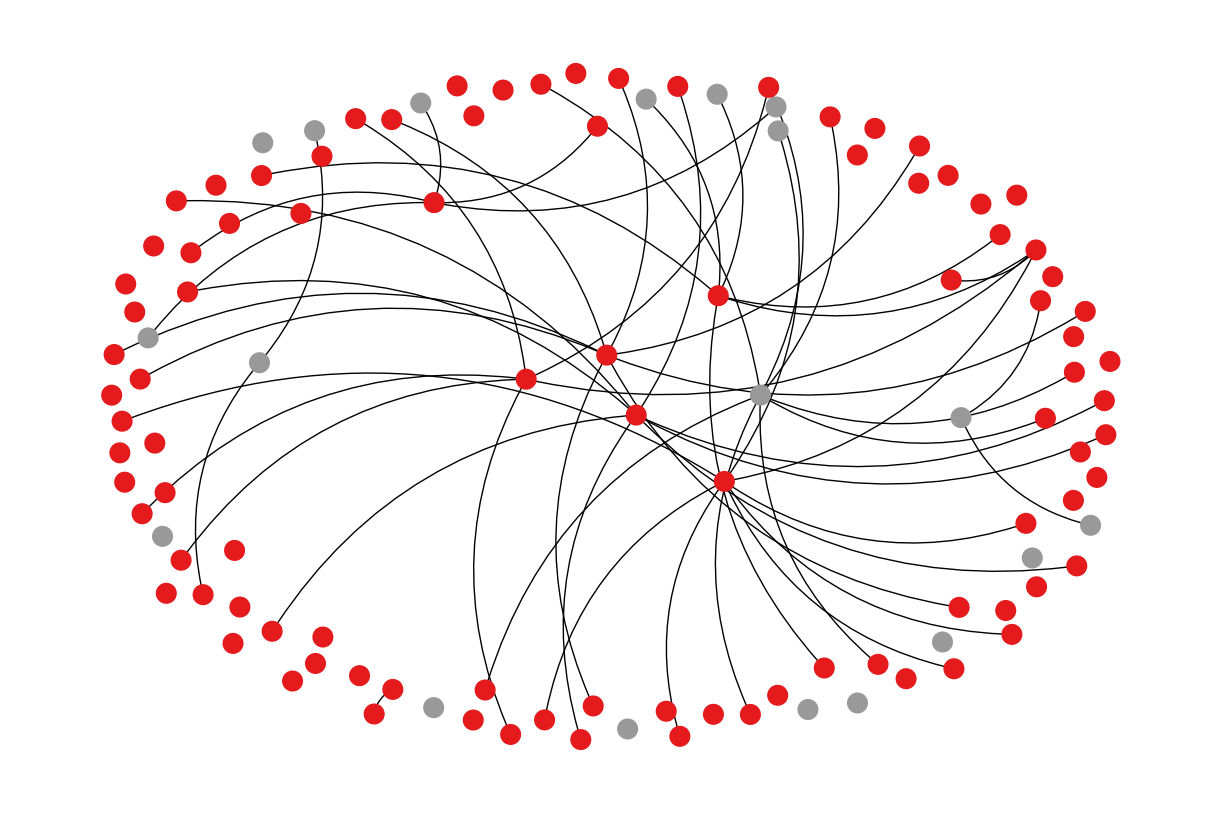

In [35]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

In [36]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 3770
validation samples 11310
test samples 22620


In [38]:
class SocialGNN(nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()


        self.conv1 = GCNConv(num_of_feat, f)

        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
          
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        return x

In [39]:
def masked_loss(predictions,labels,mask,criterion):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)  

In [40]:
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)   

In [82]:
def train_social(net,data,epochs=10,lr=0.01, criterion=nn.CrossEntropyLoss()):
    if type(lr) == list:
        partial_epoch = int(epochs/len(lr))
    else:
        partial_epoch = epochs
        lr = list(lr)

    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for learn_rate in lr:
        optimizer = torch.optim.Adam(net.parameters(), lr=learn_rate)
        
        for ep in range(partial_epoch+1):
            optimizer.zero_grad()
            out=net(data)
            loss=masked_loss(predictions=out,
                            labels=data.y,
                            mask=data.train_mask,
                            criterion=criterion)
            loss.backward()
            optimizer.step()
            train_losses+=[loss]
            train_accuracy=masked_accuracy(predictions=out,
                                        labels=data.y, 
                                        mask=data.train_mask)
            train_accuracies+=[train_accuracy]
            
            val_loss=masked_loss(predictions=out,
                                labels=data.y, 
                                mask=data.val_mask,
                                criterion=criterion)
            val_losses+=[val_loss]
            
            val_accuracy=masked_accuracy(predictions=out,
                                        labels=data.y, 
                                        mask=data.val_mask)
            val_accuracies+=[val_accuracy]

            test_accuracy=masked_accuracy(predictions=out,
                                        labels=data.y, 
                                        mask=data.test_mask)
            test_accuracies+=[test_accuracy]
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                    .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

In [83]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
train_social(net,g,epochs=600,lr=[0.1,0.001,0.0001,0.00001])

Epoch 1/600, Train_Loss: 0.7151, Train_Accuracy: 0.2682, Val_Accuracy: 0.2649, Test_Accuracy: 0.2664
Epoch 2/600, Train_Loss: 1.5306, Train_Accuracy: 0.7390, Val_Accuracy: 0.7429, Test_Accuracy: 0.7415
Epoch 3/600, Train_Loss: 0.5899, Train_Accuracy: 0.7390, Val_Accuracy: 0.7430, Test_Accuracy: 0.7416
Epoch 4/600, Train_Loss: 0.5498, Train_Accuracy: 0.7390, Val_Accuracy: 0.7430, Test_Accuracy: 0.7416
Epoch 5/600, Train_Loss: 0.6015, Train_Accuracy: 0.7390, Val_Accuracy: 0.7429, Test_Accuracy: 0.7416
Epoch 6/600, Train_Loss: 0.5935, Train_Accuracy: 0.7395, Val_Accuracy: 0.7429, Test_Accuracy: 0.7416
Epoch 7/600, Train_Loss: 0.5575, Train_Accuracy: 0.7395, Val_Accuracy: 0.7429, Test_Accuracy: 0.7416
Epoch 8/600, Train_Loss: 0.5101, Train_Accuracy: 0.7390, Val_Accuracy: 0.7429, Test_Accuracy: 0.7415
Epoch 9/600, Train_Loss: 0.4735, Train_Accuracy: 0.7390, Val_Accuracy: 0.7429, Test_Accuracy: 0.7415
Epoch 10/600, Train_Loss: 0.4657, Train_Accuracy: 0.7390, Val_Accuracy: 0.7429, Test_Accura